In [18]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [3]:
tickers = ['SPY', 'QQQ', 'BND', 'GLD', 'VTI']
end_date = datetime.now()
start_date = end_date - timedelta(days=365*10)
adj_close = pd.DataFrame()
for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date)
    adj_close[ticker] = data['Adj Close']
adj_close

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,SPY,QQQ,BND,GLD,VTI
Date,,,,,
2019-08-28,267.010834,179.296509,74.555763,145.160004,135.868210
2019-08-29,270.421295,182.037933,74.511986,144.119995,137.668793
2019-08-30,270.301270,181.602051,74.503250,143.750000,137.622635
2019-09-03,268.720703,179.839005,74.571655,145.750000,136.726929
2019-09-04,271.770813,182.435150,74.712044,146.660004,138.185959
...,...,...,...,...,...
2024-08-19,559.609985,481.269989,74.339996,231.610001,275.750000
2024-08-20,558.700012,480.260010,74.559998,232.460007,275.079987
2024-08-21,560.619995,482.500000,74.720001,232.149994,276.459991


#### Lognormal Returns

In [6]:
log_returns = np.log(adj_close / adj_close.shift(1))
log_returns = log_returns.dropna()
log_returns

,SPY,QQQ,BND,GLD,VTI
Date,,,,,
2019-08-29,0.012692,0.015174,-0.000587,-0.007190,0.013165
2019-08-30,-0.000444,-0.002397,-0.000117,-0.002571,-0.000335
2019-09-03,-0.005865,-0.009756,0.000918,0.013817,-0.006530
2019-09-04,0.011287,0.014333,0.001881,0.006224,0.010615
2019-09-05,0.012773,0.018153,-0.005181,-0.024294,0.013276
...,...,...,...,...,...
2024-08-19,0.009516,0.013050,0.001211,-0.001639,0.009400
2024-08-20,-0.001627,-0.002101,0.002955,0.003663,-0.002433
2024-08-21,0.003431,0.004653,0.002144,-0.001335,0.005004


#### Covariance Matrix

In [7]:
# 252 trading days in a year
cov_matrix = log_returns.cov()*252
cov_matrix

,SPY,QQQ,BND,GLD,VTI
SPY,0.044011,0.049816,0.003070,0.004603,0.045094
QQQ,0.049816,0.065060,0.003698,0.006022,0.050965
BND,0.003070,0.003698,0.004881,0.003867,0.003263
GLD,0.004603,0.006022,0.003867,0.023432,0.004840
VTI,0.045094,0.050965,0.003263,0.004840,0.046584


In [8]:
def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

In [9]:
# expected returns assuming they are based on historical returns
def expected_return(weights, log_returns):
    return np.sum(log_returns.mean() * weights) * 252

In [10]:
# calulating sharpe ratio
def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    ret = expected_return(weights, log_returns)
    std = standard_deviation(weights, cov_matrix)
    return (ret - risk_free_rate) / std

In [11]:
risk_free_rate = 0.034

In [12]:
# in case of scipy.optimize.minimize, there is no direct method to find the maximum value of a function
def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

In [13]:
# in my case, the constraint is that the sum of all portfolio weights should be 1. 
# bounds are limits placed on portfolio weights and each weight should be between 0 and 1
# 0 =>  we can't go short on any asset
# 0.5 => we can't allocate more than 50% of the portfolio to any asset
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = [(0, 0.5) for i in range(len(tickers))]    # 0 <= weight <= 0.5

In [15]:
initial_weights = np.array([1/len(tickers)]*len(tickers))
initial_weights

array([0.2, 0.2, 0.2, 0.2, 0.2])

In [16]:
optimised_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', bounds=bounds, constraints=constraints)

In [17]:
optimisal_weights = optimised_results.x

In [20]:
for ticker, weight in zip(tickers, optimisal_weights):
    print(f'{ticker}: {weight:.4f}%')
optimal_portfolio_return = expected_return(optimisal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimisal_weights, cov_matrix)
optimal_sharpr_ratio = sharpe_ratio(optimisal_weights, log_returns, cov_matrix, risk_free_rate)
print(f'Expected return: {optimal_portfolio_return:.4f}')
print(f'Volatility: {optimal_portfolio_volatility:.4f}')
print(f'Sharpe ratio: {optimal_sharpr_ratio:.4f}')

SPY: 0.0000%
QQQ: 0.5000%
BND: 0.0000%
GLD: 0.5000%
VTI: 0.0000%
Expected return: 0.1460
Volatility: 0.1585
Sharpe ratio: 0.7062


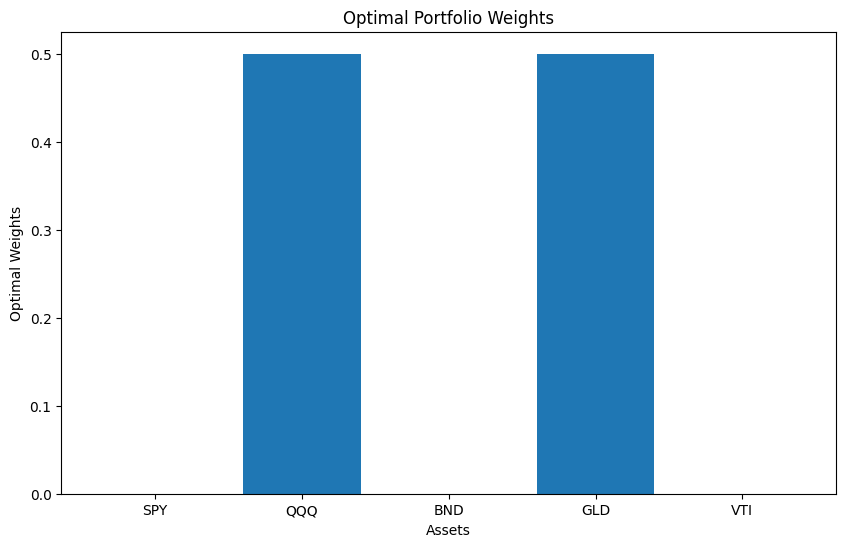

In [21]:
plt.figure(figsize=(10, 6))
plt.bar(tickers, optimisal_weights)

plt.title('Optimal Portfolio Weights')
plt.xlabel('Assets')
plt.ylabel('Optimal Weights')

plt.show()